In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import os
import urllib
import zipfile
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
from PIL import Image
from torchvision.models import resnet18
from collections import Counter, OrderedDict

In [9]:
!unzip /content/drive/MyDrive/Dataset/CelebA_Dataset.zip > /dev/null

In [10]:
attributes = ['Arched_Eyebrows', 'Black_Hair', 'Narrow_Eyes', 'Smiling', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Necklace', 'Young']

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [12]:
count = 0
for file in os.listdir('/content/img_align_celeba'):
  count += 1


count

202599

In [37]:
n_epochs = 2

In [14]:
df = pd.read_csv('/content/list_attr_celeba.txt', sep="\s+", skiprows=1, index_col=0, usecols=attributes)
df

,Arched_Eyebrows,Black_Hair,Narrow_Eyes,Smiling,Wavy_Hair,Wearing_Earrings,Wearing_Necklace,Young
000001.jpg,1,-1,-1,1,-1,1,-1,1
000002.jpg,-1,-1,-1,1,-1,-1,-1,1
000003.jpg,-1,-1,1,-1,1,-1,-1,1
000004.jpg,-1,-1,-1,-1,-1,1,1,1
000005.jpg,1,-1,1,-1,-1,-1,-1,1
...,...,...,...,...,...,...,...,...
202595.jpg,-1,-1,-1,-1,-1,-1,-1,1
202596.jpg,-1,-1,1,1,-1,-1,-1,1
202597.jpg,-1,1,-1,1,-1,-1,-1,1
202598.jpg,1,1,-1,1,1,1,-1,1


In [15]:
type(df.values)
df = df.replace(-1, 0)

# Preprocesing the Dataset

Devide dataset into 80% for training and 20% for test.

In [16]:
num_train_examples = int(df.shape[0]*0.8)
df_train = df.iloc[:num_train_examples, :]
df_test = df.iloc[num_train_examples:, :]

df_train.to_csv('celeba_gender_attr_train.txt', sep=" ")
df_test.to_csv('celeba_gender_attr_test.txt', sep=" ")



In [17]:
for attr in attributes:
    print(f'Number of {attr} in training dataset:')
    print(len(df_train['Arched_Eyebrows'].values))
    break
# print(f'Number of {attr} in training dataset:')
# np.bincount(df_train['Arched_Eyebrows'].values)

Number of Arched_Eyebrows in training dataset:
162079


(218, 178, 3)


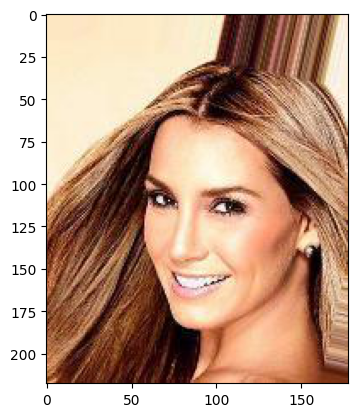

In [18]:
img = Image.open('img_align_celeba/000001.jpg')
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img);

In [19]:
class CelebaDataset(Dataset):
    """Custom Dataset for loading CelebA face images"""

    def __init__(self, txt_path, img_dir, transform=None):
    
        df = pd.read_csv(txt_path, sep=" ", index_col=0)
        self.img_dir = img_dir
        self.txt_path = txt_path
        self.img_names = df.index.values
        self.y_Arched_Eyebrows = df['Arched_Eyebrows'].values
        self.y_Black_Hair = df['Black_Hair'].values
        self.y_Narrow_Eyes = df['Narrow_Eyes'].values
        self.y_Smiling = df['Smiling'].values
        self.y_Wavy_Hair = df['Wavy_Hair'].values
        self.y_Wearing_Earrings = df['Wearing_Earrings'].values
        self.y_Wearing_Necklace = df['Wearing_Necklace'].values
        self.y_Young = df['Young'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label_Arched_Eyebrows = self.y_Arched_Eyebrows[index]
        label_Black_Hair = self.y_Black_Hair[index]
        label_Narrow_Eyes = self.y_Narrow_Eyes[index]
        label_Smiling = self.y_Smiling[index]
        label_Wavy_Hair = self.y_Wavy_Hair[index]
        label_Wearing_Earrings = self.y_Wearing_Earrings[index]
        label_Wearing_Necklace = self.y_Wearing_Necklace[index]
        label_Young = self.y_Young[index]
        return img, label_Arched_Eyebrows, label_Black_Hair, label_Narrow_Eyes,label_Smiling, label_Wavy_Hair, label_Wearing_Earrings, label_Wearing_Necklace, label_Young

    def __len__(self):
        return self.y_Arched_Eyebrows.shape[0]


# Train Model & Dataset

In [20]:
df_train[attributes[0]].values

array([1, 0, 0, ..., 0, 1, 0])

In [21]:
custom_transform = transforms.Compose([transforms.Resize((64,64)),                                      
                                       transforms.ToTensor()])

train_dataset = CelebaDataset(txt_path='celeba_gender_attr_train.txt',
                              img_dir='img_align_celeba/',
                              transform=custom_transform)

In [22]:
train_dataset.__getitem__(0)

(tensor([[[0.9922, 0.9922, 0.9922,  ..., 0.7412, 0.9490, 0.9922],
          [0.9922, 0.9922, 0.9922,  ..., 0.8000, 0.9686, 0.9882],
          [0.9922, 0.9922, 0.9922,  ..., 0.8588, 0.9765, 0.9843],
          ...,
          [0.7765, 0.7216, 0.5333,  ..., 0.4471, 0.4902, 0.5216],
          [0.6784, 0.6039, 0.5098,  ..., 0.4039, 0.3922, 0.3882],
          [0.6196, 0.7176, 0.5569,  ..., 0.4706, 0.4588, 0.4549]],
 
         [[0.9059, 0.9059, 0.9059,  ..., 0.6275, 0.8784, 0.9255],
          [0.9059, 0.9059, 0.9059,  ..., 0.6863, 0.9059, 0.9255],
          [0.9059, 0.9059, 0.9059,  ..., 0.7608, 0.9294, 0.9294],
          ...,
          [0.5176, 0.4549, 0.2745,  ..., 0.2235, 0.2667, 0.3137],
          [0.4196, 0.3373, 0.2431,  ..., 0.1529, 0.1490, 0.1490],
          [0.3529, 0.4471, 0.2824,  ..., 0.2000, 0.1922, 0.1922]],
 
         [[0.7608, 0.7608, 0.7608,  ..., 0.4235, 0.7451, 0.8745],
          [0.7608, 0.7608, 0.7608,  ..., 0.5098, 0.7961, 0.8706],
          [0.7608, 0.7608, 0.7608,  ...,

In [23]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=128,
                          shuffle=True) 

In [24]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y_0, y_1, y_2, y_3, y_4, y_5,y_6,y_7) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y_1.shape)
        
        x = x.to(device)
        y_0 = y_0.to(device)
        y_1 = y_1.to(device)
        y_2 = y_2.to(device)
        y_3 = y_3.to(device)
        y_4 = y_4.to(device)
        y_5 = y_5.to(device)
        y_6 = y_6.to(device)
        y_7 = y_7.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: torch.Size([128])
Epoch: 2 | Batch index: 0 | Batch size: torch.Size([128])


In [25]:
x.shape

torch.Size([128, 3, 64, 64])

In [26]:
one_image = x[127].permute(1, 2, 0)
one_image.shape
# y_1

torch.Size([64, 64, 3])

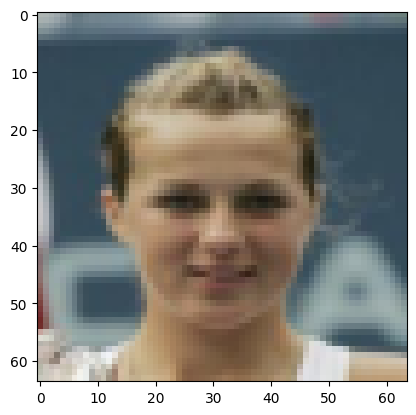

In [27]:
plt.imshow(one_image.to(torch.device('cpu')).squeeze(), cmap='gray');

In [28]:
model = resnet18(pretrained=True)
model.fc.out_features = 2
model.fc.out_features

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 184MB/s]


2

In [30]:
class MultiTaskLearning(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = resnet18(pretrained=True)
        self.n_features = self.net.fc.in_features
        self.net.fc = nn.Identity()

        self.net.fc0 = nn.Linear(self.n_features, 2)
        self.net.fc1 = nn.Linear(self.n_features, 2)
        self.net.fc2 = nn.Linear(self.n_features, 2)
        self.net.fc3 = nn.Linear(self.n_features, 2)
        self.net.fc4 = nn.Linear(self.n_features, 2)
        self.net.fc5 = nn.Linear(self.n_features, 2)        
        self.net.fc6 = nn.Linear(self.n_features, 2)
        self.net.fc7 = nn.Linear(self.n_features, 2)
        
    def forward(self, x):
        ae = self.net.fc0(self.net(x))
        # print("For: ",ae.shape)
        bh = self.net.fc1(self.net(x))
        ne = self.net.fc2(self.net(x))
        sm = self.net.fc3(self.net(x))
        wh = self.net.fc4(self.net(x))
        we = self.net.fc5(self.net(x))
        wn = self.net.fc6(self.net(x))
        yo = self.net.fc7(self.net(x))
        return ae, bh, ne, sm, wh, we, wn, yo

In [31]:
model = MultiTaskLearning().to(device=device)
model

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MultiTaskLearning(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [32]:
ae_loss = nn.CrossEntropyLoss() 
bh_loss = nn.CrossEntropyLoss()
ne_loss = nn.CrossEntropyLoss()
sm_loss = nn.CrossEntropyLoss()
wh_loss = nn.CrossEntropyLoss()
we_loss = nn.CrossEntropyLoss()
wn_loss = nn.CrossEntropyLoss()
yo_loss = nn.CrossEntropyLoss()

In [33]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.09)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.0001
    maximize: False
    momentum: 0.09
    nesterov: False
    weight_decay: 0
)

In [34]:
for i, data in enumerate(tqdm(train_loader)):
  print(data[8])
  break

  0%|          | 0/1267 [00:00<?, ?it/s]

tensor([1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
        0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])


In [35]:
task = {'ae':[], 'bh':[]}

task["ae"].append(1)
task['ae'].append(2)
task['ae'].append(3)
task['bh'].append(1)
task['bh'].append(1)
task['bh'].append(1)

task

{'ae': [1, 2, 3], 'bh': [1, 1, 1]}

In [36]:
task_acc = {'ae' : [], 'bh': [], 'ne': [], 'sm': [], 'wh': [], 'we': [], 'wn': [],'yo': []}
ep_acc = []
ep_loss = []
n_cls = 8


print("Trainging Loop:")

for epoch in range(n_epochs):
    model.train()
    total_training_loss = 0
    acc = 0
   
    for i, data in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        inputs = data[0].to(device=device)
        
        ae_label = data[1].to(device=device)
        # print("Original size: ",ae_label)
        bh_label = data[2].to(device=device)
        ne_label = data[3].to(device=device)
        sm_label = data[4].to(device=device)
        wh_label = data[5].to(device=device)
        we_label = data[6].to(device=device)
        wn_label = data[7].to(device=device)
        yo_label = data[8].to(device=device)
        
        
        optimizer.zero_grad()
        ae_out, bh_out, ne_out, sm_out, wh_out, we_out, wn_out, yo_out = model(inputs)
        
        loss_0 = ae_loss(ae_out, ae_label).float()
        loss_1 = bh_loss(bh_out, bh_label).float()
        loss_2 = ne_loss(ne_out, ne_label).float()
        loss_3 = sm_loss(sm_out, sm_label).float()
        loss_4 = wh_loss(wh_out, wh_label).float()
        loss_5 = we_loss(we_out, we_label).float()
        loss_6 = wn_loss(wn_out, wn_label).float()
        loss_7 = yo_loss(yo_out, yo_label).float()
        
        loss = loss_0 + loss_1 + loss_2 + loss_3 + loss_4 + loss_5 + loss_6 + loss_7
        loss.backward()
        optimizer.step()

        with torch.no_grad():
          pred1 = torch.argmax(ae_out, dim=1)
          pred2 = torch.argmax(bh_out, dim=1)
          pred3 = torch.argmax(ne_out, dim=1)
          pred4 = torch.argmax(sm_out, dim=1)
          pred5 = torch.argmax(wh_out, dim=1)
          pred6 = torch.argmax(we_out, dim=1)
          pred7 = torch.argmax(wn_out, dim=1)
          pred8 = torch.argmax(yo_out, dim=1)


          # Calculate the accuracy for each class
          acc1 = torch.mean((pred1 == ae_label).float()).item()
          acc2 = torch.mean((pred2 == bh_label).float()).item()
          acc3 = torch.mean((pred3 == ne_label).float()).item()
          acc4 = torch.mean((pred4 == sm_label).float()).item()
          acc5 = torch.mean((pred5 == wh_label).float()).item()
          acc6 = torch.mean((pred6 == we_label).float()).item()
          acc7 = torch.mean((pred7 == wn_label).float()).item()
          acc8 = torch.mean((pred8 == yo_label).float()).item()

          task_acc['ae'].append(acc1)
          task_acc['bh'].append(acc2)
          task_acc['ne'].append(acc3)
          task_acc['sm'].append(acc4)
          task_acc['wh'].append(acc5)
          task_acc['we'].append(acc6)
          task_acc['wn'].append(acc7)
          task_acc['yo'].append(acc8)
          
        
    total_training_loss += loss.item()
    avg_accuracy = (acc1 + acc2 + acc3 + acc4 + acc5 + acc6 + acc7 + acc8)/n_cls 

    ep_loss.append(total_training_loss)
    ep_acc.append(avg_accuracy)



    print('Epoch {}'.format(epoch+1))
    print('loss: {:.4f}'.format(total_training_loss))
    print('Accuracy: {:.4f}'.format(avg_accuracy*100))
    print('Accuracy for Arched_Eyebrows : {:.2f}%'.format(acc1 * 100))
    print('Accuracy for Black_Hair : {:.2f}%'.format(acc2 * 100))
    print('Accuracy for Narrow_Eyes : {:.2f}%'.format(acc3 * 100))
    print('Accuracy for Smiling : {:.2f}%'.format(acc4 * 100))
    print('Accuracy for Wavy_Hair : {:.2f}%'.format(acc5 * 100))
    print('Accuracy for Wearing_Earrings : {:.2f}%'.format(acc6 * 100))
    print('Accuracy for Wearing_Necklace : {:.2f}%'.format(acc7 * 100))
    print('Accuracy for Young : {:.2f}%'.format(acc8 * 100))

Trainging Loop:


  0%|          | 0/1267 [00:00<?, ?it/s]

Epoch 1
loss: 4.2875
Accuracy: 74.1935
Accuracy for Arched_Eyebrows : 70.97%
Accuracy for Black_Hair : 74.19%
Accuracy for Narrow_Eyes : 93.55%
Accuracy for Smiling : 58.06%
Accuracy for Wavy_Hair : 51.61%
Accuracy for Wearing_Earrings : 83.87%
Accuracy for Wearing_Necklace : 83.87%
Accuracy for Young : 77.42%


  0%|          | 0/1267 [00:00<?, ?it/s]

Epoch 2
loss: 3.3833
Accuracy: 82.2581
Accuracy for Arched_Eyebrows : 70.97%
Accuracy for Black_Hair : 74.19%
Accuracy for Narrow_Eyes : 90.32%
Accuracy for Smiling : 70.97%
Accuracy for Wavy_Hair : 83.87%
Accuracy for Wearing_Earrings : 90.32%
Accuracy for Wearing_Necklace : 87.10%
Accuracy for Young : 90.32%


  0%|          | 0/1267 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [41]:
ep_acc

[0.7419354617595673, 0.8225806280970573]

In [46]:
ep_loss

[4.2875, 3.3833]

In [49]:
task

{'ae': [1, 2, 3],
 'bh': [1, 3, 2],
 'ch': [1, 2, 3],
 'de': [1, 3, 2],
 'fg': [2, 3, 1]}

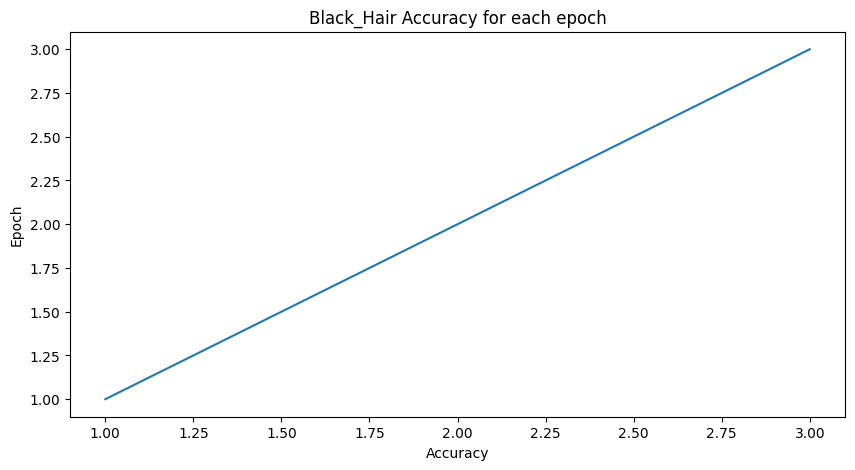

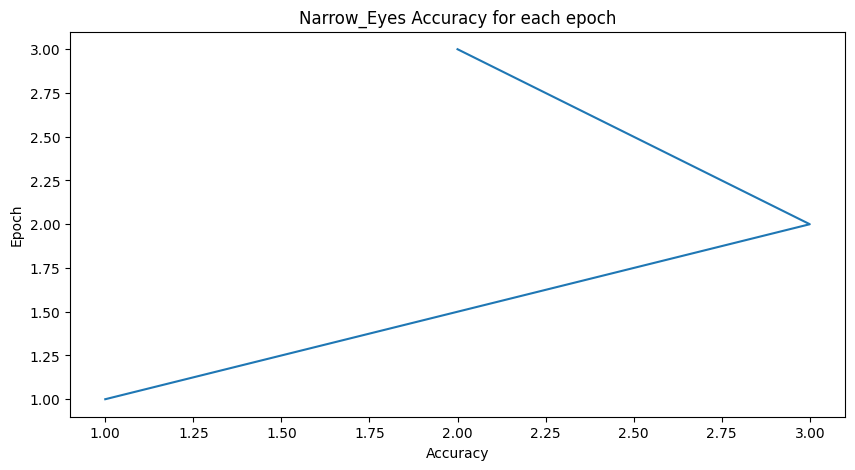

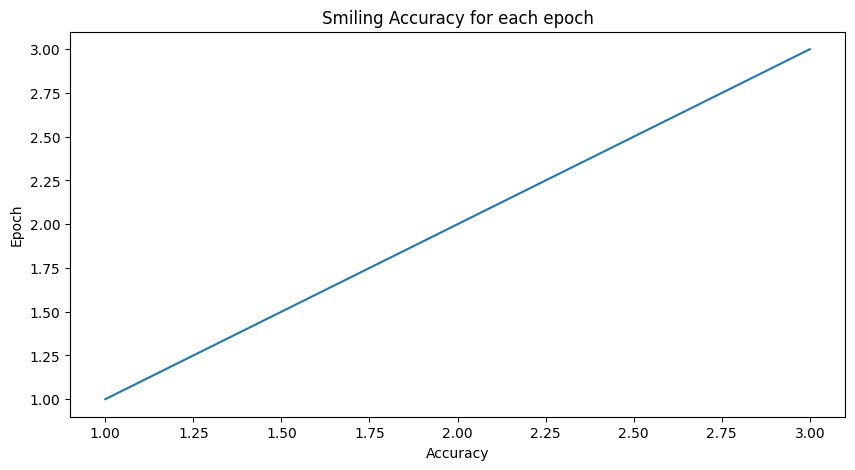

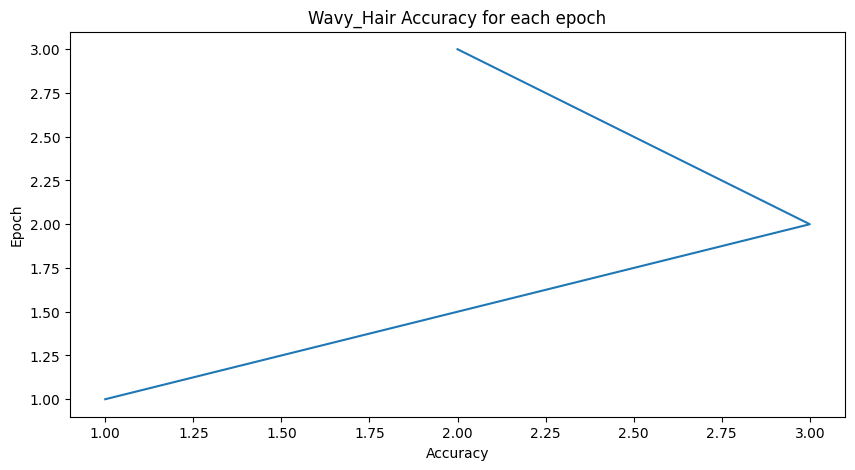

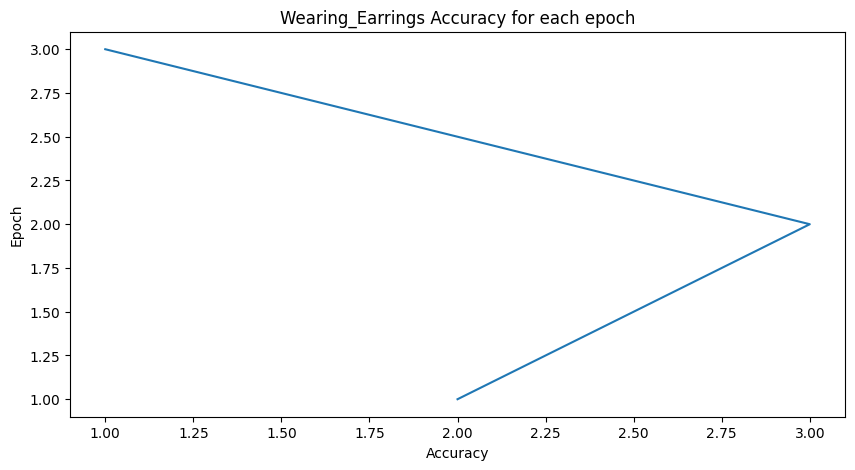

In [47]:
import numpy as np
import matplotlib.pyplot as plt

ep_list = [i+1 for i in range(3)]
task = {'ae':[], 'bh':[], 'ch':[], 'de':[], 'fg':[]}
attributes = ['Arched_Eyebrows', 'Black_Hair', 'Narrow_Eyes', 'Smiling', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Necklace', 'Young']

task["ae"].append(1)
task['ae'].append(2)
task['ae'].append(3)

task['bh'].append(1)
task['bh'].append(3)
task['bh'].append(2)

task['ch'].append(1)
task['ch'].append(2)
task['ch'].append(3)

task['de'].append(1)
task['de'].append(3)
task['de'].append(2)

task['fg'].append(2)
task['fg'].append(3)
task['fg'].append(1)

task

def plotGraph(x, y, string):
    # Convert list to numpy array
    x = np.array(x)
    y = np.array(y)
    # chart show

    # set chart Size
    fig = plt.figure()  
      
    fig.set_figheight(5)  
    fig.set_figwidth(10)  

    #plot 1: Loss vs Accuracy
    plt.title(string)
    plt.xlabel("Accuracy")
    plt.ylabel("Epoch")
    # plt.subplot(1, 4, 1)
    plt.plot(x,y)
    plt.show()



i = 0
for x in task:
  i+=1
  plotGraph(task[x], ep_list, f"{attributes[i]} Accuracy for each epoch")


ValueError: ignored

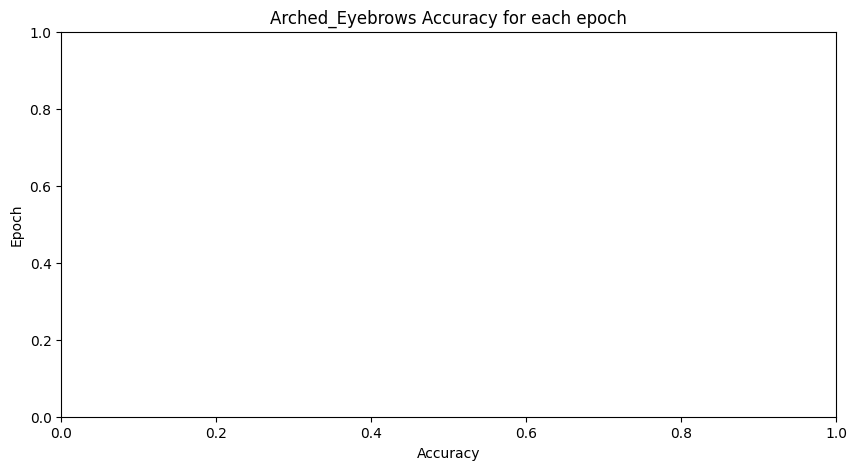

In [50]:
ep_list = [i+1 for i in range(n_epochs)]

def plotGraph(x, y, string):
    # Convert list to numpy array
    x = np.array(x)
    y = np.array(y)
    # chart show

    # set chart Size
    fig = plt.figure()  
      
    fig.set_figheight(5)  
    fig.set_figwidth(10)  

    #plot 1: Loss vs Accuracy
    plt.title(string)
    plt.xlabel("Accuracy")
    plt.ylabel("Epoch")
    # plt.subplot(1, 4, 1)
    plt.plot(x,y)
    plt.show()


i = 0
for x in task_acc:
  plotGraph(task_acc[x], ep_list, f"{attributes[i]} Accuracy for each epoch")
  i+=1


plotGraph(ep_acc, ep_list, f"Overall Accuracy for each epoch")
plotGraph(ep_loss, ep_list, f"Overall Accuracy for each epoch")

# Test Model & dataset

In [51]:
for attr in attributes:
    print(f'Number of {attr} in training dataset:')
    print(len(df_train['Arched_Eyebrows'].values))
    break

Number of Arched_Eyebrows in training dataset:
162079


In [52]:
df_test[attributes[0]].values

array([0, 0, 0, ..., 0, 1, 1])

In [53]:
custom_transform = transforms.Compose([transforms.Resize((64,64)),                                      
                                       transforms.ToTensor()])

test_dataset = CelebaDataset(txt_path='celeba_gender_attr_test.txt',
                              img_dir='img_align_celeba/',
                              transform=custom_transform)

In [54]:
test_dataset.__getitem__(0)

(tensor([[[0.3137, 0.2980, 0.2980,  ..., 0.3059, 0.3059, 0.3059],
          [0.3137, 0.2980, 0.2980,  ..., 0.3098, 0.3098, 0.3098],
          [0.3137, 0.3020, 0.2980,  ..., 0.3137, 0.3137, 0.3137],
          ...,
          [0.3020, 0.3020, 0.3020,  ..., 0.3922, 0.4078, 0.4275],
          [0.3020, 0.3020, 0.3020,  ..., 0.4235, 0.4275, 0.4275],
          [0.2980, 0.3020, 0.3059,  ..., 0.1765, 0.2784, 0.3647]],
 
         [[0.5294, 0.5216, 0.5255,  ..., 0.5451, 0.5451, 0.5451],
          [0.5294, 0.5216, 0.5255,  ..., 0.5490, 0.5490, 0.5490],
          [0.5294, 0.5255, 0.5255,  ..., 0.5529, 0.5529, 0.5529],
          ...,
          [0.5255, 0.5255, 0.5255,  ..., 0.6078, 0.6196, 0.6235],
          [0.5255, 0.5255, 0.5255,  ..., 0.5882, 0.6118, 0.6157],
          [0.5216, 0.5255, 0.5294,  ..., 0.2902, 0.4314, 0.5412]],
 
         [[0.7922, 0.7843, 0.7843,  ..., 0.8000, 0.8000, 0.8000],
          [0.7922, 0.7843, 0.7843,  ..., 0.8039, 0.8039, 0.8039],
          [0.7922, 0.7882, 0.7843,  ...,

In [55]:
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=4) 

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [56]:
num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y_0, y_1, y_2, y_3, y_4, y_5,y_6,y_7) in enumerate(test_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y_1.shape)
        
        x = x.to(device)
        y_0 = y_0.to(device)
        y_1 = y_1.to(device)
        y_2 = y_2.to(device)
        y_3 = y_3.to(device)
        y_4 = y_4.to(device)
        y_5 = y_5.to(device)
        y_6 = y_6.to(device)
        y_7 = y_7.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: torch.Size([128])
Epoch: 2 | Batch index: 0 | Batch size: torch.Size([128])


In [57]:
x.shape

torch.Size([128, 3, 64, 64])

In [58]:
one_image = x[127].permute(1, 2, 0)
one_image.shape
# y_1

torch.Size([64, 64, 3])

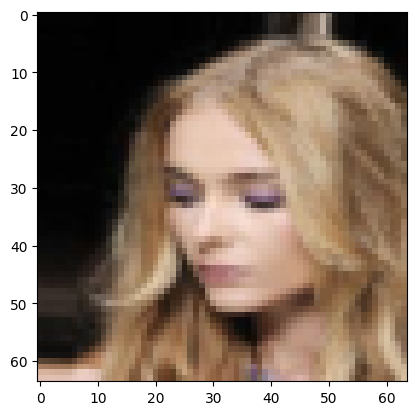

In [59]:
plt.imshow(one_image.to(torch.device('cpu')).squeeze(), cmap='gray');

In [60]:
model.eval()
test_task_acc = {'ae' : [], 'bh': [], 'ne': [], 'sm': [], 'wh': [], 'we': [], 'wn': [],'yo': []}
test_ep_loss = []
test_ep_acc = []

total_testing_loss = 0
avg_accuracy = 0
print("Testing Loop:")
for i, data in enumerate(tqdm(test_loader)):
    with torch.no_grad():
        inputs = data[0].to(device=device)
        ae_label = data[1].to(device=device)
        # print("Original size: ",ae_label)
        bh_label = data[2].to(device=device)
        ne_label = data[3].to(device=device)
        sm_label = data[4].to(device=device)
        wh_label = data[5].to(device=device)
        we_label = data[6].to(device=device)
        wn_label = data[7].to(device=device)
        yo_label = data[8].to(device=device)

        ae_out, bh_out, ne_out, sm_out, wh_out, we_out, wn_out, yo_out = model(inputs)

        loss = loss_0 + loss_1 + loss_2 + loss_3 + loss_4 + loss_5 + loss_6 + loss_7


        pred1 = torch.argmax(ae_out, dim=1)
        pred2 = torch.argmax(bh_out, dim=1)
        pred3 = torch.argmax(ne_out, dim=1)
        pred4 = torch.argmax(sm_out, dim=1)
        pred5 = torch.argmax(wh_out, dim=1)
        pred6 = torch.argmax(we_out, dim=1)
        pred7 = torch.argmax(wn_out, dim=1)
        pred8 = torch.argmax(yo_out, dim=1)


        # Calculate the accuracy for each class
        acc1 = torch.mean((pred1 == ae_label).float()).item()
        acc2 = torch.mean((pred2 == bh_label).float()).item()
        acc3 = torch.mean((pred3 == ne_label).float()).item()
        acc4 = torch.mean((pred4 == sm_label).float()).item()
        acc5 = torch.mean((pred5 == wh_label).float()).item()
        acc6 = torch.mean((pred6 == we_label).float()).item()
        acc7 = torch.mean((pred7 == wn_label).float()).item()
        acc8 = torch.mean((pred8 == yo_label).float()).item()

        test_task_acc['ae'].append(acc1)
        test_task_acc['bh'].append(acc2)
        test_task_acc['ne'].append(acc3)
        test_task_acc['sm'].append(acc4)
        test_task_acc['wh'].append(acc5)
        test_task_acc['we'].append(acc6)
        test_task_acc['wn'].append(acc7)
        test_task_acc['yo'].append(acc8)

    total_testing_loss += loss
    avg_accuracy = (acc1 + acc2 + acc3 + acc4 + acc5 + acc6 + acc7 + acc8)/n_cls 

    # test_ep_loss.append(total_training_loss)
    # test_ep_acc.append(avg_accuracy)

print('loss: {:.4f}'.format(total_training_loss))
print('Accuracy: {:.4f}'.format(avg_accuracy * 100))
print('Accuracy for Arched_Eyebrows : {:.2f}%'.format(acc1 * 100.0))
print('Accuracy for Black_Hair : {:.2f}%'.format(acc2 * 100.0))
print('Accuracy for Narrow_Eyes : {:.2f}%'.format(acc3 * 100.0))
print('Accuracy for Smiling : {:.2f}%'.format(acc4 * 100.0))
print('Accuracy for Wavy_Hair : {:.2f}%'.format(acc5 * 100.0))
print('Accuracy for Wearing_Earrings : {:.2f}%'.format(acc6 * 100.0))
print('Accuracy for Wearing_Necklace : {:.2f}%'.format(acc7 * 100.0))
print('Accuracy for Young : {:.2f}%'.format(acc8 * 100.0))

Testing Loop:


  0%|          | 0/317 [00:00<?, ?it/s]

loss: 0.0000
Accuracy: 79.6875
Accuracy for Arched_Eyebrows : 75.00%
Accuracy for Black_Hair : 77.78%
Accuracy for Narrow_Eyes : 91.67%
Accuracy for Smiling : 65.28%
Accuracy for Wavy_Hair : 77.78%
Accuracy for Wearing_Earrings : 80.56%
Accuracy for Wearing_Necklace : 88.89%
Accuracy for Young : 80.56%
